# Summary statistics + exploratory data analysis
report:
- sample size (by mode/dataset, if needed)
- mapping of distribution of origin/destination of trips
- time of day distribution
- trip distance/travel time distribution
- breakdown by mode


## potential bottlenecks
- spatial join is built on geopandas/pandas --> slow for very large datasets?
- how to choose a proper support/confidence threshold?

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
import seaborn as sns
# import plotly_express as px
import folium
from folium.plugins import HeatMap

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
import pyspark.pandas as ps
from zipfile import ZipFile
from glob import glob
import os

## Data collection

In [2]:
# toy data: Jan 2015 citibike data
# data = pd.read_csv('data/201501-citibike-tripdata_1.csv')

In [3]:
path = "data/2023-citibike-tripdata"
# glob.glob(path/+'*.csv')
ext = "*.csv"
all_csv_files = [file 
                 for path, subdir, files in os.walk(path) 
                 for file in glob(os.path.join(path, ext))]

In [121]:
all_csv_files

['data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_3.csv',
 'data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_2.csv',
 'data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_1.csv',
 'data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_2.csv',
 'data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_3.csv',
 'data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_1.csv',
 'data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_1.csv',
 'data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_2.csv',
 'data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_3.csv',
 'data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_4.csv',
 'data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_1.csv',
 'data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_3.csv',
 'data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_2.csv',
 'data/2023-citibike-tripdata/10_October/202310-citibike-

In [153]:
# read one file to get an idea of data distribution. choosing april b/c that is when HTS is conducted.
data1 = pd.read_csv(all_csv_files[0])
data2 = pd.read_csv(all_csv_files[1])
data3 = pd.read_csv(all_csv_files[2])

data = pd.concat([data1, data2, data3])

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_4389/1777987323.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv(all_csv_files[0])
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_4389/1777987323.py:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv(all_csv_files[1])
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_4389/1777987323.py:4: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv(all_csv_files[2])


In [154]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9388A6CB0FB20BA6,classic_bike,2023-04-19 16:50:36,2023-04-19 16:58:53,Leonard St & Church St,5359.11,W 17 St & 8 Ave,6148.02,40.717580,-74.005672,40.741776,-74.001497,member
1,164F7BA30F9B8B8E,electric_bike,2023-04-18 17:02:18,2023-04-18 17:03:55,Grand Ave & Bergen St,4190.06,Bergen St & Vanderbilt Ave,4157.10,40.678045,-73.962408,40.679439,-73.968044,member
2,10E16DD7DACDDBD0,classic_bike,2023-04-17 14:25:48,2023-04-17 14:32:12,Graham Ave & Grand St,5178.06,Driggs Ave & S 2 St,5235.10,40.711827,-73.944007,40.710000,-73.960000,member
3,CEAE2DF5AAD61183,classic_bike,2023-04-20 21:28:47,2023-04-20 21:42:02,Graham Ave & Grand St,5178.06,Driggs Ave & S 2 St,5235.10,40.711863,-73.944024,40.710000,-73.960000,member
4,992CF2B93656E3A7,classic_bike,2023-04-14 19:52:07,2023-04-14 19:59:33,8 Ave & W 16 St,6072.11,8 Ave & W 31 St,6450.05,40.740983,-74.001702,40.750585,-73.994685,member


## data viz

In [155]:
# read in shapefile of nyc
nyc = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

In [156]:
# convert time strings to datetime objects
data['starttime'] = pd.to_datetime(data['started_at'])
data['stoptime'] = pd.to_datetime(data['ended_at'])
data['duration'] = pd.to_timedelta(data['stoptime'] - data['starttime']).dt.total_seconds() / 60

# create geodataframe of data
# start points
data_start = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['start_lng'], data['start_lat'])).set_crs(nyc.crs)
# end points
data_end = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['end_lng'], data['end_lat'])).set_crs(nyc.crs)

In [157]:
# assign census tract information to data
data_start_census = gpd.sjoin(data_start, nyc[["GEOID", "geometry"]], predicate='within', how='left')
data_end_census = gpd.sjoin(data_end, nyc[["GEOID", "geometry"]], predicate='within', how='left')

In [158]:
# sample size
print("n =", len(data))

n = 2854350


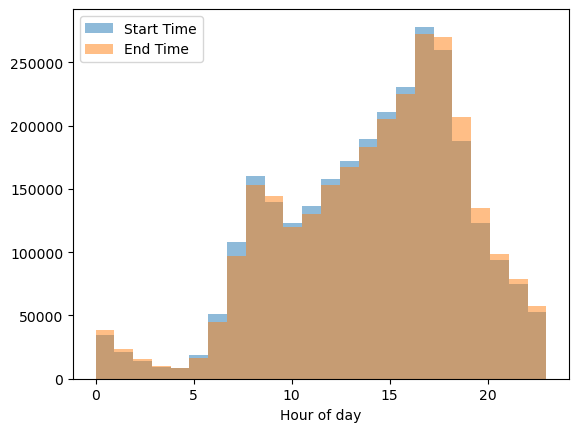

In [163]:
# distribution of start times
plt.hist(data['starttime'].dt.hour, bins=24, alpha=0.5, label='Start Time')
plt.hist(data['stoptime'].dt.hour, bins=24, alpha=0.5, label='End Time')

# plot as kde
# sns.histplot(data['starttime'].dt.hour, label='Start Time')
# sns.histplot(data['stoptime'].dt.hour, label='End Time')
plt.xlabel('Hour of day')
# plt.title('Distribution of trip times by hour, April 2023')
plt.legend()

#save
plt.savefig('figs/trip_times_by_hour.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean duration:  15.693510250436473
Median duration:  9.2


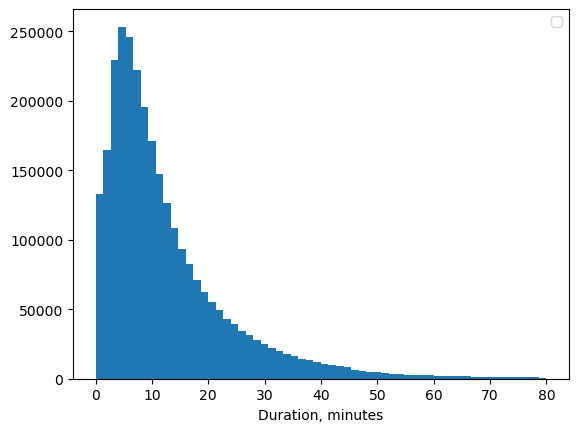

In [164]:
mean_dur = data['duration'].mean()
median_dur = data['duration'].median()

# mean_str = "Mean: {}".format(round(mean_dur, 2))
# median_str = "Median: {}".format(round(median_dur, 2))

# distribution of travel times
plt.hist(data['duration'], range=(0,80), bins=60)
# add mean line
# plt.axvline(mean_dur, color='red', linestyle='--', label=mean_str)
# add median line
# plt.axvline(median_dur, color='black', linestyle='--', label=median_str)
# plt.title("Distribution of trip times (minutes), April 2023")
plt.xlabel("Duration, minutes")
plt.legend()

print("Mean duration: ", mean_dur)
print("Median duration: ", median_dur)

# save
plt.savefig('figs/trip_times.png')

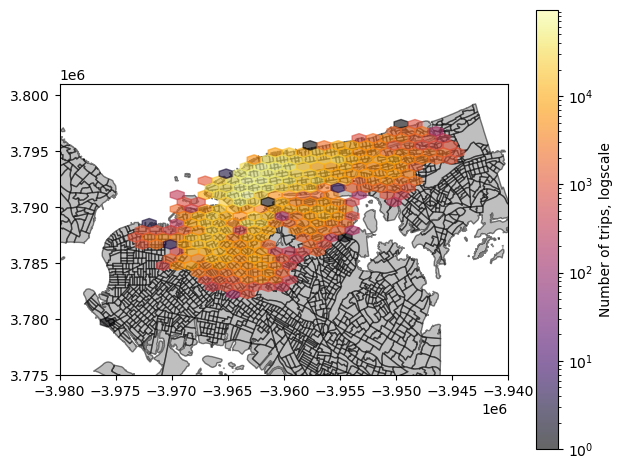

24/05/03 16:16:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 932707 ms exceeds timeout 120000 ms
24/05/03 16:16:48 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/03 16:25:44 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [165]:
# issues...hex bins look stretched (fix projections)

f, ax = plt.subplots()
x = data_start.to_crs("epsg:9822")['geometry'].x
y = data_start.to_crs("epsg:9822")['geometry'].y


nyc.to_crs("epsg:9822").plot(ax=ax, color='grey', alpha=0.5, edgecolor='k')
# hb = ax.hexbin(x, y, gridsize=25, cmap='inferno', mincnt=1)
hb = ax.hexbin(x, y, gridsize=25, cmap='inferno', mincnt=1, norm=matplotlib.colors.LogNorm(), alpha=0.6)
plt.colorbar(hb, label='Number of trips, logscale')
# set extent
ax.set_xlim(-3.98e6, -3.94e6)
ax.set_ylim(3.775e6, 3.801e6)

# plt.title("Density of Citi Bike trips in New York City, April 2023")
plt.tight_layout()

# save
plt.savefig('figs/trip_density.png')

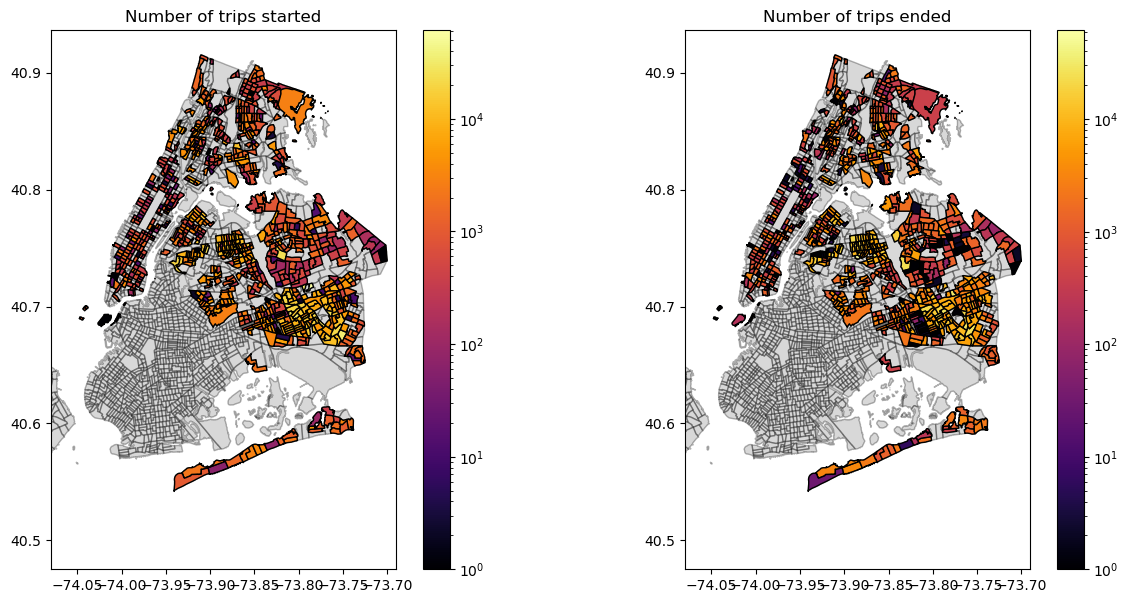

<Figure size 640x480 with 0 Axes>

In [162]:
# plot points per census tract, choropleth
nyc["numtrips_start"] = data_start_census.groupby('GEOID').count().duration.reset_index().duration
nyc["numtrips_end"] = data_end_census.groupby('GEOID').count().duration.reset_index().duration

f, ax = plt.subplots(1, 2, figsize=(15, 7))
nyc.plot(ax=ax[0], color='grey', alpha=0.3, edgecolor='k')
nyc.plot(column='numtrips_start', ax=ax[0], legend=True, cmap='inferno', edgecolor='k', norm=matplotlib.colors.LogNorm(vmin=nyc["numtrips_start"].min(), vmax=nyc["numtrips_start"].max()))
ax[0].set_title('Number of trips started')
# set extent
ax[0].set_xlim(-74.08, -73.69)

nyc.plot(ax=ax[1], color='grey', alpha=0.3, edgecolor='k')
nyc.plot(column='numtrips_end', ax=ax[1], legend=True, cmap='inferno', edgecolor='k', norm=matplotlib.colors.LogNorm(vmin=nyc["numtrips_end"].min(), vmax=nyc["numtrips_end"].max()))
ax[1].set_title('Number of trips ended')
# # set extent
ax[1].set_xlim(-74.08, -73.69)
plt.show()

# save
plt.savefig('figs/trips_per_tract.png')

In [ ]:
# try heatmap of start trips instead, plot
# fig = px.density_mapbox(data_start, lat='start station latitude', lon='start station longitude', radius=10, zoom=10, mapbox_style='carto-positron')
# fig.show()

# folium map
# m = folium.Map(location=[40.7, -74], zoom_start=12)
# hm = HeatMap(data_start[['start station latitude', 'start station longitude']], radius=10).add_to(m)

# m


## reporting summary stats of entire dataset from 2023

In [60]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

24/05/03 09:59:03 WARN Utils: Your hostname, Kaitlyns-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.18.153.41 instead (on interface en0)
24/05/03 09:59:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/03 09:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [82]:
data_23 = spark.read.csv(all_csv_files, header=True)

In [83]:
print(f"sample size: n={data_23.count()}")

sample size: n=36226600


In [84]:
# reformat time columns
data_23 = data_23.withColumn('starttime', F.to_timestamp(data_23['started_at']))
data_23 = data_23.withColumn('stoptime', F.to_timestamp(data_23['ended_at']))
data_23 = data_23.withColumn('duration', (F.col('stoptime').cast('long') - F.col('starttime').cast('long')) / 60)

# drop unnecessary columns
data_23 = data_23.drop('start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'member_casual', 'rideable_type')

In [119]:
# what is the mean and sd of duration?
data_23.select(F.mean('duration'), F.stddev('duration')).show()


+------------------+-----------------+
|     avg(duration)| stddev(duration)|
+------------------+-----------------+
|14.911200308612933|66.99643649312225|
+------------------+-----------------+



## some research into mining frequent itemsets using python packages
Algorithm: Apriori (or FP growth?)

- MLXtend
- itemset-mining
- apyori
- PyCaret
- MLlib (FP-growth)-- this is what we used in the colab


### note
- do the data processing below in spark instead so we can use `pyspark.ml.fpm`


In [ ]:
# combine start and end data, to get start and end census
data_census = pd.concat([data, data_start_census[["GEOID"]].rename(columns={"GEOID":"start_tract"}), data_end_census[["GEOID"]].rename(columns={"GEOID":"end_tract"})], axis=1)

# only keep certain columns
data_subset = data_census[["starttime", "stoptime", "start_tract", "end_tract", "tripduration"]]
data_subset

data_cat = pd.DataFrame()
# make variables categorical for start/stop time and trip duration
# maybe bin by 0-5, 5-15, 15+?
data_cat["tripduration"] = pd.cut(data_subset["tripduration"], bins=[0, 300, 900, np.inf], labels=["0-5", "5-15", "15+"])
# bin by morning peak (7-9), evening peak (4-7), mid-day (10-4), night (8-6)
data_cat["starttime"] = pd.cut(data_subset["starttime"].dt.hour, bins=[-0.5, 7, 10, 16, 19, 24], labels=["offpeak night", "morning peak", "offpeak day", "evening peak", "offpeak night"], ordered=False)
data_cat["stoptime"] = pd.cut(data_subset["stoptime"].dt.hour, bins=[-0.5, 7, 10, 16, 19, 24], labels=["offpeak night", "morning peak", "offpeak day", "evening peak", "offpeak night"], ordered=False)

data_cat["start_tract"] = data_subset["start_tract"]
data_cat["end_tract"] = data_subset["end_tract"]

data_cat["od_pair"] = data_cat.apply(lambda x: [x["start_tract"], x["end_tract"]], axis=1)


In [ ]:
# how many entries have same start and end tract?
print(data_cat[data_cat["start_tract"] == data_cat["end_tract"]].shape[0]/data_cat.shape[0])

# only 3%...drop these items for now.
data_cat = data_cat[data_cat["start_tract"] != data_cat["end_tract"]]

In [ ]:
# convert to spark dataframe
data_spark = spark.createDataFrame(data_cat)
data_spark.printSchema()

In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="od_pair", minSupport=0.001, minConfidence=0.5) # question: how to choose support and confidence?
model = fpGrowth.fit(data_spark)

# Display frequent itemsets.
model.freqItemsets.sort(desc("freq")).show()

In [ ]:
# only look at frequent pairs
model.freqItemsets.filter(F.size(F.col("items")) == 2).sort(F.col("freq").desc()).show()

In [ ]:
# take top n pairs...then perform similarity analysis on all trips that contain these pairs